# Artistic Style Transfer

There are many amazing photo editing app like Prisma and PicArts can produce some style transfer visual effects.

We will discuss and implement the code for a similar visual effect like below. This picture is taken from [Harish Narayanan's blog](https://harishnarayanan.org/writing/artistic-style-transfer/).

<img src="images/style-transferred.png" alt="VGGNet" style="width: 400px;"/>

The abstract of [the paper](https://arxiv.org/abs/1508.06576) we will follow today:

> In fine art, especially painting, humans have mastered the skill to create unique
visual experiences through composing a complex interplay between the content
and style of an image. Thus far the algorithmic basis of this process is
unknown and there exists no artificial system with similar capabilities. However,
in other key areas of visual perception such as object and face recognition
near-human performance was recently demonstrated by a class of biologically
inspired vision models called Deep Neural Networks. Here we introduce an
artificial system based on a Deep Neural Network that creates artistic images
of high perceptual quality. The system uses neural representations to separate
and recombine content and style of arbitrary images, providing a neural
algorithm for the creation of artistic images. Moreover, in light of the striking
similarities between performance-optimised artificial neural networks and
biological vision, our work offers a path forward to an algorithmic understanding
of how humans create and perceive artistic imagery.

## Preparation

In [1]:
import time
from PIL import Image # image loading and processing
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16 # pre-trained VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
# The VGG16 model we use here requires (1, 512, 512, 3) image
HEIGHT = 512
WIDTH = 512
CONTENT_IMAGE_PATH = 'images/bird.jpg'
STYLE_IMAGE_PATH = 'images/wave.png'

## Load Images

For a style transfer task, we need a content image to modify, and a style image as our transfer reference.

The content image we will keep using is still this photo of a bird. 
And the style image we'd like to use is a Japanese traditional drawing.

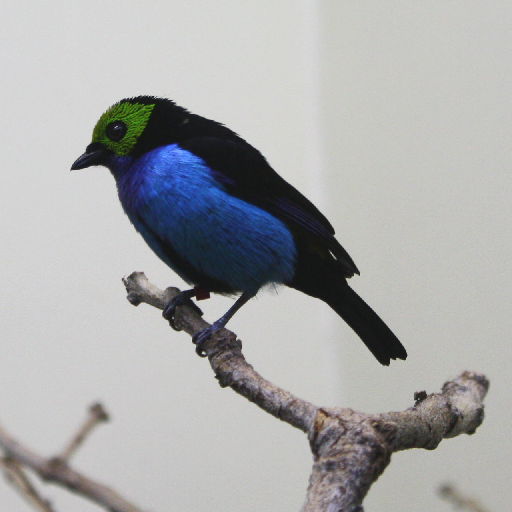

In [3]:
content_image = Image.open(CONTENT_IMAGE_PATH)
content_image = content_image.resize((HEIGHT, WIDTH))
content_image

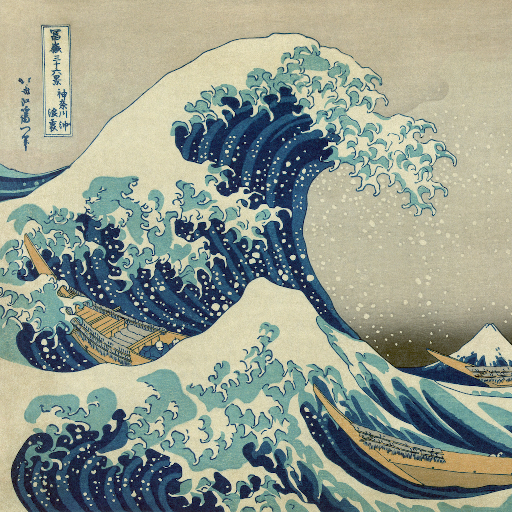

In [4]:
style_image = Image.open(STYLE_IMAGE_PATH)
style_image = style_image.resize((HEIGHT, WIDTH))
style_image

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print('Shape of the content image:', content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print('Shape of the style image:', style_array.shape)

Shape of the content image: (1, 512, 512, 3)
Shape of the style image: (1, 512, 512, 3)


For this, we need to perform two transformations (from Harish Narayanan's blog):

- Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
- Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

In [6]:
# You can find a similar implementation in the Keras documentation
def preprocess_input(x):
    """Preprocesses a tensor encoding a batch of images.
    
    Source: https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py
    Modified by Kulbear@GitHub
    
    # Arguments
        x: input Numpy tensor, 4D.
    # Returns
        Preprocessed tensor.
    """
    # 'RGB'->'BGR'
    x = x[:, :, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    
    return x

In [7]:
content_array = preprocess_input(content_array)
style_array = preprocess_input(style_array)

Now, we concatenate all image data into a single tensor.

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, HEIGHT, WIDTH, 3))

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Load the Pre-trained VGGNet(16) Model

In [9]:
model = VGG16(input_tensor=input_tensor, 
              weights='imagenet',
              include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

In [10]:
content_weight = 0.025
style_weight = 7 # range 5-8 looks good
total_variation_weight = 1.0
loss = backend.variable(0.)

## Content Loss

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2'] # can switch to others layer, try it by yourself
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

## Style Loss

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [12]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [13]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = HEIGHT * WIDTH
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

## Total Variation Loss

The total variation loss (a regularisation term) that encourages spatial smoothness.

In [14]:
def total_variation_loss(x):
    a = backend.square(x[:, :HEIGHT-1, :WIDTH-1, :] - x[:, 1:, :WIDTH-1, :])
    b = backend.square(x[:, :HEIGHT-1, :WIDTH-1, :] - x[:, :HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Solve the Optimization Problem

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads

In [15]:
# Define the gradients
grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, HEIGHT, WIDTH, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Let's Do It...

In [16]:
x = np.random.uniform(0, 255, (1, HEIGHT, WIDTH, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value -->', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value --> 8.14409e+10
Iteration 0 completed in 49s
Start of iteration 1
Current loss value --> 5.93135e+10
Iteration 1 completed in 36s
Start of iteration 2
Current loss value --> 4.84678e+10
Iteration 2 completed in 37s
Start of iteration 3
Current loss value --> 4.30349e+10
Iteration 3 completed in 37s
Start of iteration 4
Current loss value --> 4.02636e+10
Iteration 4 completed in 37s
Start of iteration 5
Current loss value --> 3.87011e+10
Iteration 5 completed in 37s
Start of iteration 6
Current loss value --> 3.77581e+10
Iteration 6 completed in 37s
Start of iteration 7
Current loss value --> 3.7258e+10
Iteration 7 completed in 37s
Start of iteration 8
Current loss value --> 3.69672e+10
Iteration 8 completed in 37s
Start of iteration 9
Current loss value --> 3.6762e+10
Iteration 9 completed in 37s


In [17]:
def postprocess_output(x):
    """Postprocesses the style transferred image.
    
    # Arguments
        x: input Numpy tensor, 4D.
    # Returns
        Postprocessed tensor.
    """
    x = x.reshape((HEIGHT, WIDTH, 3))
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    return x

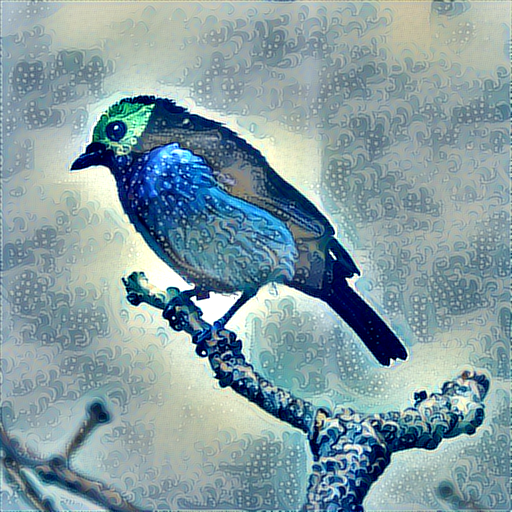

In [18]:
x = postprocess_output(x)
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

## Reference and Further Reading

- **[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) --> The core idea of this notebook is from this paper!**
- **[Convolutional neural networks for artistic style transfer](https://harishnarayanan.org/writing/artistic-style-transfer/) --> Harish Narayanan's blog**
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

These two implementation below are written in Lua/Torch, its syntax is easy to understand.

- **[jcjohnson/neural-style @ Github](https://github.com/jcjohnson/neural-style)**
- [jcjohnson/fast-neural-style @ GitHub](https://github.com/jcjohnson/fast-neural-style)